In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, preprocessing, metrics
import xgboost as xgb
import os
import time
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

/kaggle/dev/ashish/instacart-market-basket-analysis/insta/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# constants
DATA_PATH = '/kaggle/dev/instacart-market-basket-analysis-data/raw_data/'
PREPROCESSED_DATA_PATH = '/kaggle/dev/instacart-market-basket-analysis-data/preprocessed_data/'
SUBMISSIONS_PATH = '/kaggle/dev/instacart-market-basket-analysis-data/submissions/'
MODEL_PERFORMANCE_PATH = '/kaggle/dev/instacart-market-basket-analysis-data/model_performance_data/'

In [3]:
# loading the data
aisles = pd.read_csv(os.path.join(DATA_PATH, 'aisles.csv'))
departments = pd.read_csv(os.path.join(DATA_PATH, 'departments.csv'))
order_products_prior = pd.read_csv(os.path.join(DATA_PATH, 'order_products__prior.csv'))
order_products_train = pd.read_csv(os.path.join(DATA_PATH, 'order_products__train.csv'))
orders = pd.read_csv(os.path.join(DATA_PATH, 'orders.csv'))
products = pd.read_csv(os.path.join(DATA_PATH, 'products.csv'))
sample_submission = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))

In [7]:
order_products = pd.concat([order_products_prior, order_products_train])
assert(len(order_products) == len(order_products_prior) + len(order_products_train))
order_products.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [9]:
product_catalog = pd.merge(products, departments, on='department_id', how='inner')
product_catalog = pd.merge(product_catalog, aisles, on='aisle_id', how='inner')
product_catalog.head()

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,78,Nutter Butter Cookie Bites Go-Pak,61,19,snacks,cookies cakes
2,102,Danish Butter Cookies,61,19,snacks,cookies cakes
3,172,Gluten Free All Natural Chocolate Chip Cookies,61,19,snacks,cookies cakes
4,285,Mini Nilla Wafers Munch Pack,61,19,snacks,cookies cakes


In [17]:
product_catalog

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,78,Nutter Butter Cookie Bites Go-Pak,61,19,snacks,cookies cakes
2,102,Danish Butter Cookies,61,19,snacks,cookies cakes
3,172,Gluten Free All Natural Chocolate Chip Cookies,61,19,snacks,cookies cakes
4,285,Mini Nilla Wafers Munch Pack,61,19,snacks,cookies cakes
5,331,Organic Lemon Gingersnap,61,19,snacks,cookies cakes
6,449,Chips Ahoy! Chewy Cookies,61,19,snacks,cookies cakes
7,559,Cookie Chips Crunchy Dark Chocolate Chocolate ...,61,19,snacks,cookies cakes
8,569,Golden Cupcakes 8 Pack,61,19,snacks,cookies cakes
9,574,Crunch Vanilla Sugar Mini Cookies,61,19,snacks,cookies cakes


In [19]:
order_product_catalog = pd.merge(order_products, product_catalog, on='product_id', how='left')
order_product_catalog.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,dairy eggs,eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,produce,fresh vegetables
2,2,9327,3,0,Garlic Powder,104,13,pantry,spices seasonings
3,2,45918,4,1,Coconut Butter,19,13,pantry,oils vinegars
4,2,30035,5,0,Natural Sweetener,17,13,pantry,baking ingredients


In [95]:
top_users = orders[orders.eval_set != 'test'].groupby(['user_id']).order_number.max().reset_index().sort_values('order_number', ascending=False)
top_users.head()

,user_id,order_number
112840,112841,100
174554,174555,100
73675,73676,100
176468,176469,100
90583,90584,100


In [96]:
def generate_user_plots(user_id):
    print('------ Plots for user_id ', user_id, '------')
    # Get user orders product catalog
    user_order_product_catalog = pd.merge(orders[orders.user_id == user_id], order_product_catalog, on='order_id', how='left')
    user_order_product_catalog = user_order_product_catalog.sort_values(['user_id', 'order_number', 'add_to_cart_order'])
    train_order_products = set(user_order_product_catalog[user_order_product_catalog.eval_set=='train'].product_name.values)
   
    # Plot order count vs. day of week
    dows = user_order_product_catalog.order_dow.values
    ax = sns.distplot(dows, kde=False, color="b")
    ax.set(xlabel='day_of_week', ylabel='order count')
    plt.show()
    # Plot order count vs. hour of day
    hods = user_order_product_catalog.order_hour_of_day.values
    ax = sns.distplot(hods, kde=False, color="b")
    ax.set(xlabel='hour_of_day', ylabel='order count')
    plt.show()
    
    # Plot product count vs. product name - products ordered in train_order in RED
    fig, ax = plt.subplots(figsize=(20, 10))
    products = user_order_product_catalog.groupby('product_name').aisle_id.count().reset_index().rename(columns={'aisle_id': 'counts'}).sort_values('counts',ascending=False)
    x = products.product_name.values
    y = products.counts.values
    ax = sns.barplot(x, y, palette="BuGn_d", ax=ax)
    ax.set(xlabel='product_name', ylabel='order count')
    plt.setp(ax.get_xticklabels(), rotation=90)
    for xtick in ax.get_xticklabels():
        if xtick.get_text() in train_order_products:
            xtick.set_color('r')
    plt.show()

------ Plots for user_id  112841 ------


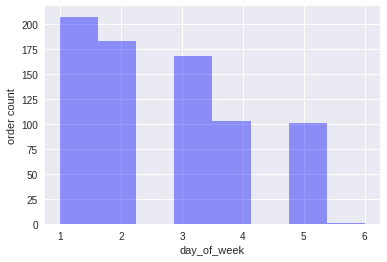

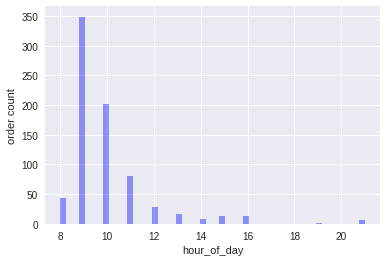

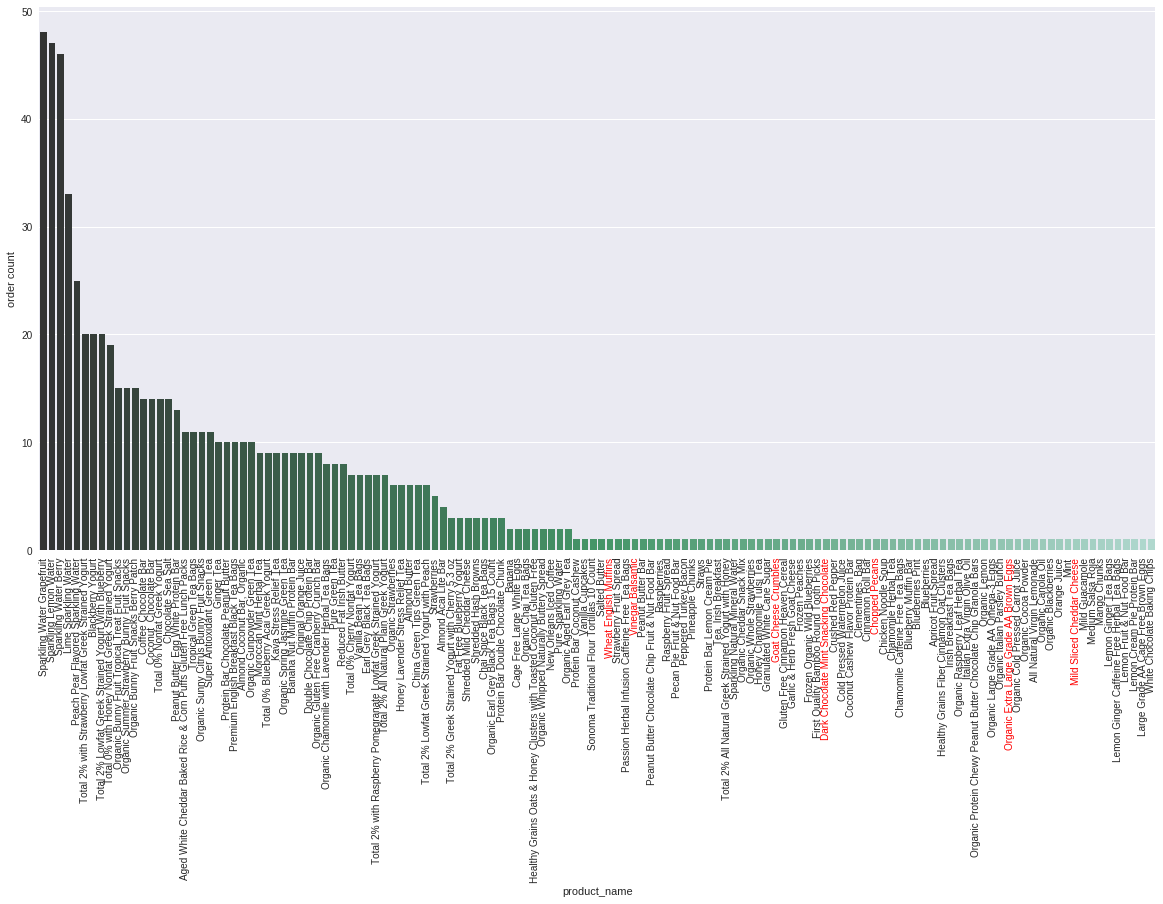

------ Plots for user_id  174555 ------


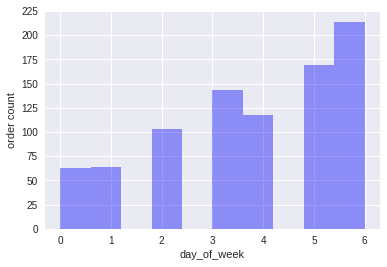

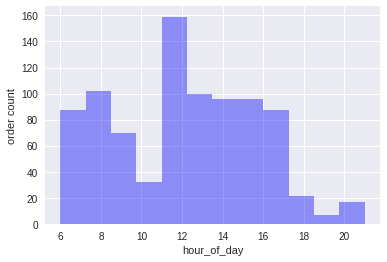

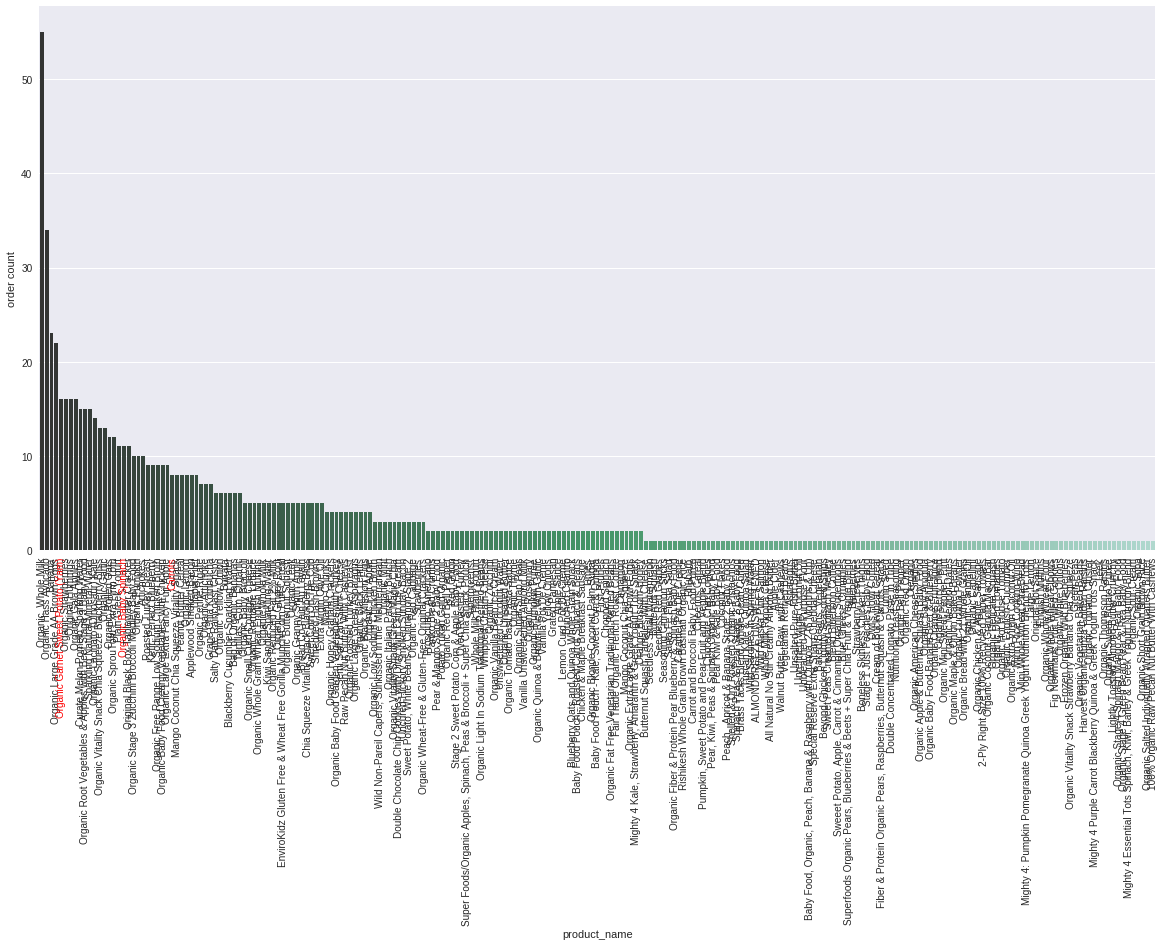

------ Plots for user_id  73676 ------


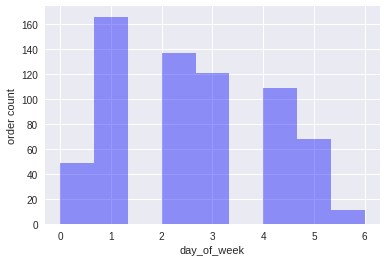

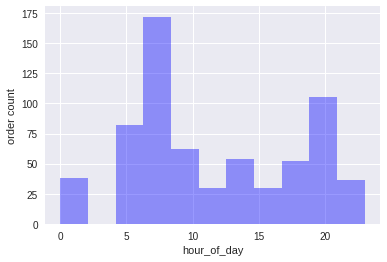

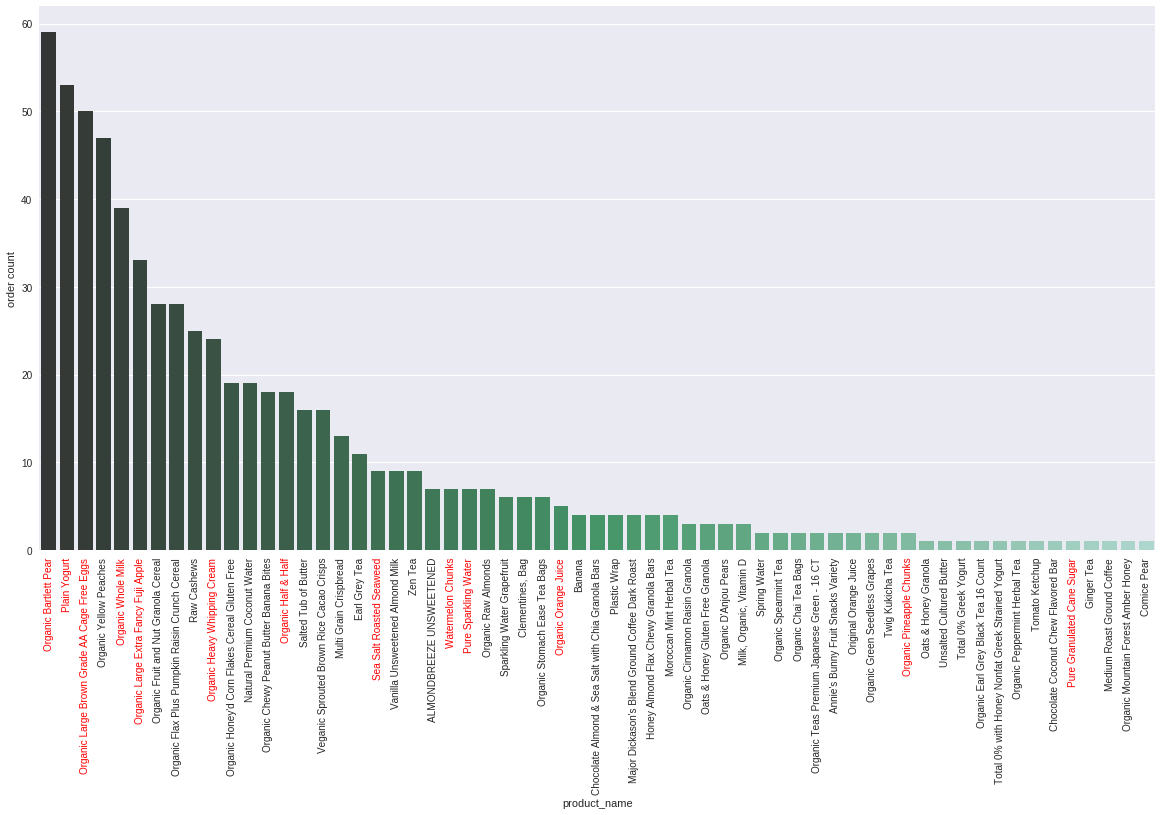

------ Plots for user_id  176469 ------


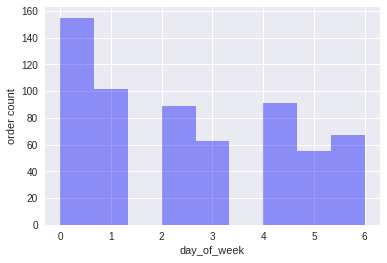

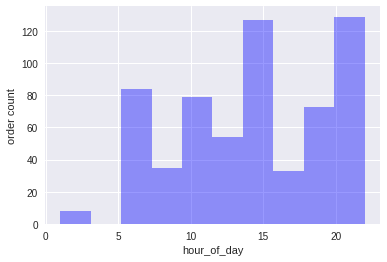

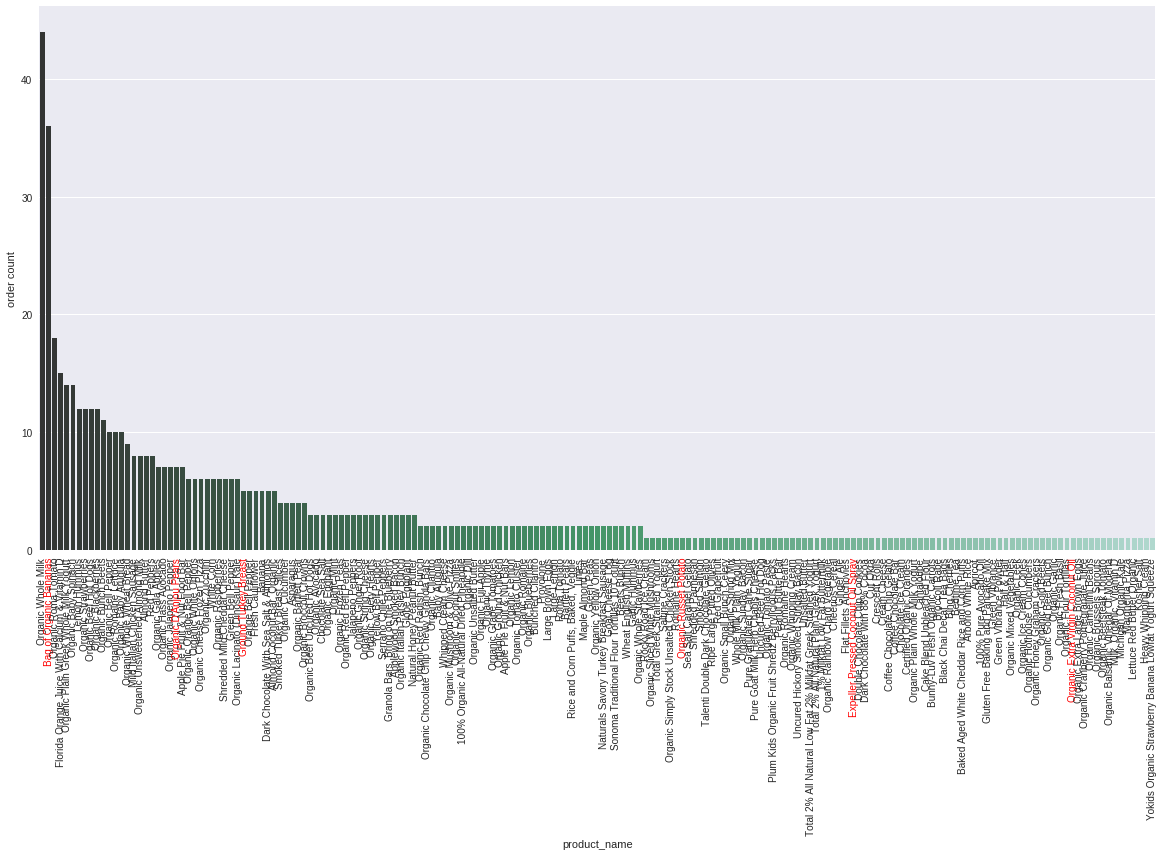

------ Plots for user_id  90584 ------


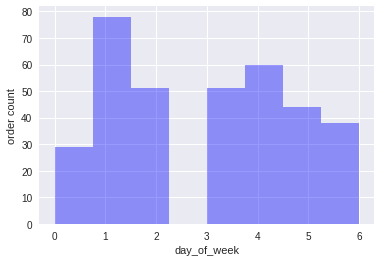

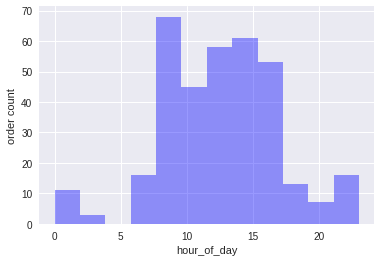

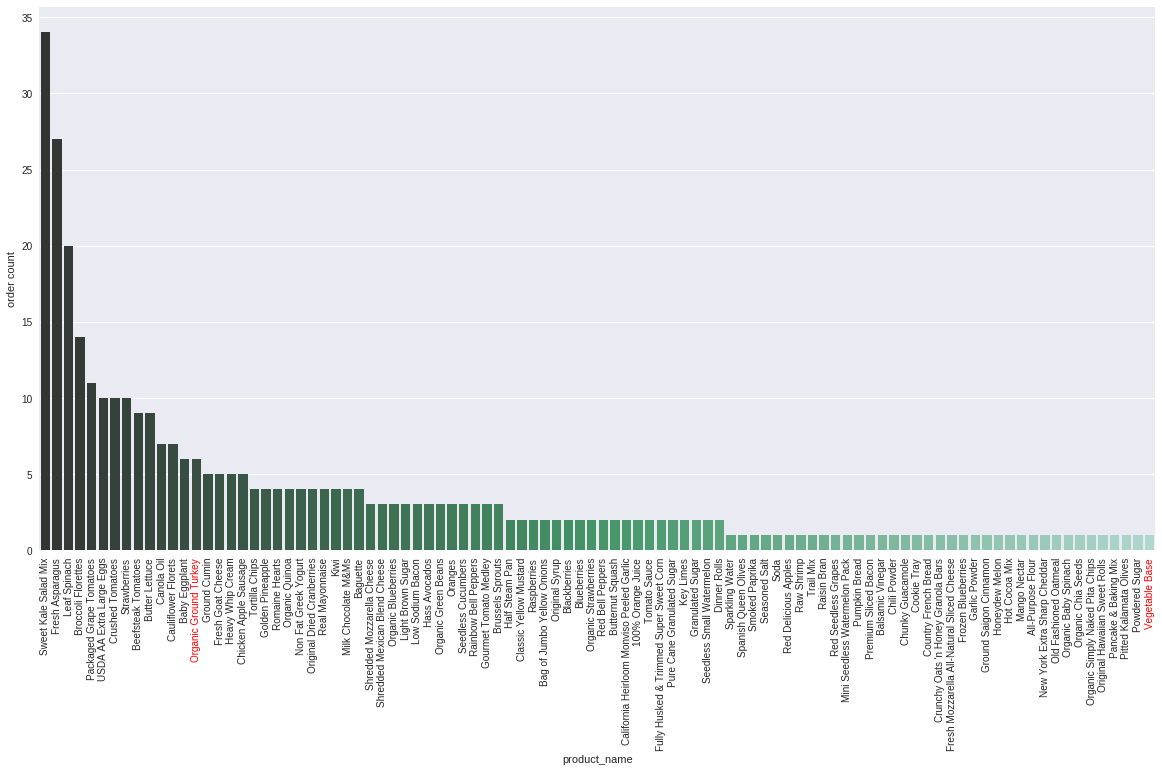

------ Plots for user_id  190487 ------


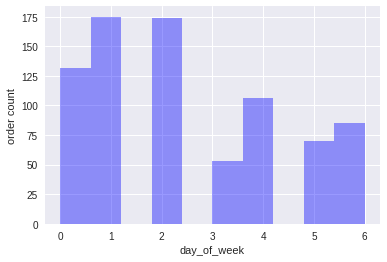

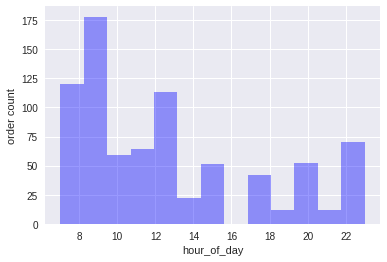

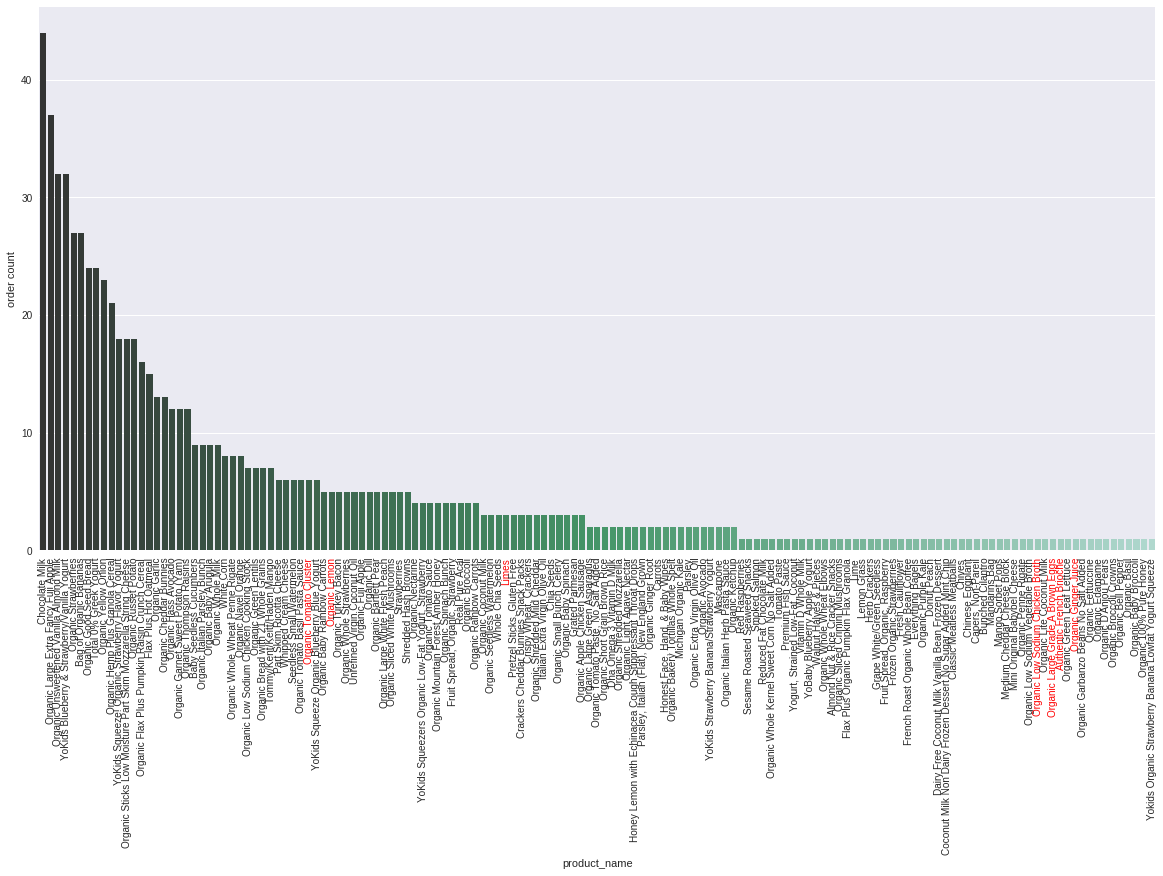

------ Plots for user_id  57367 ------


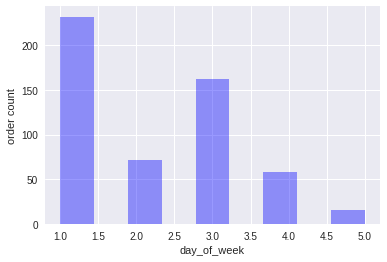

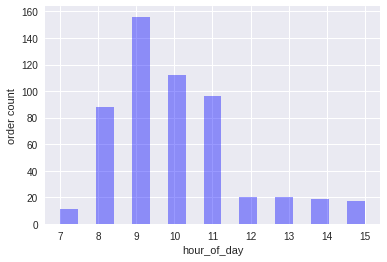

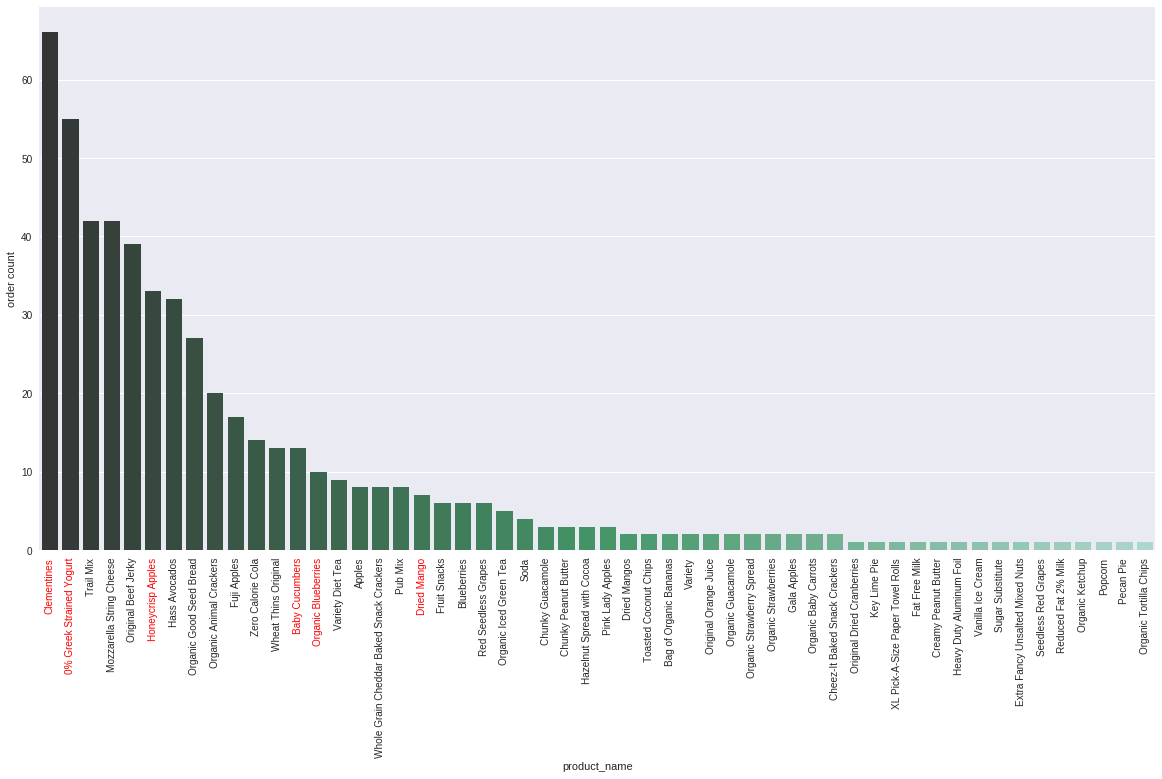

------ Plots for user_id  81549 ------


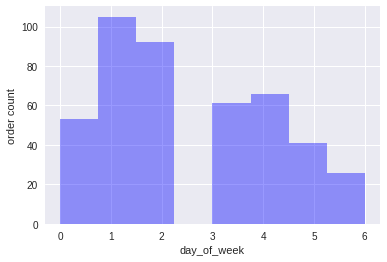

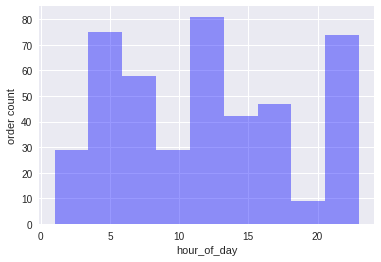

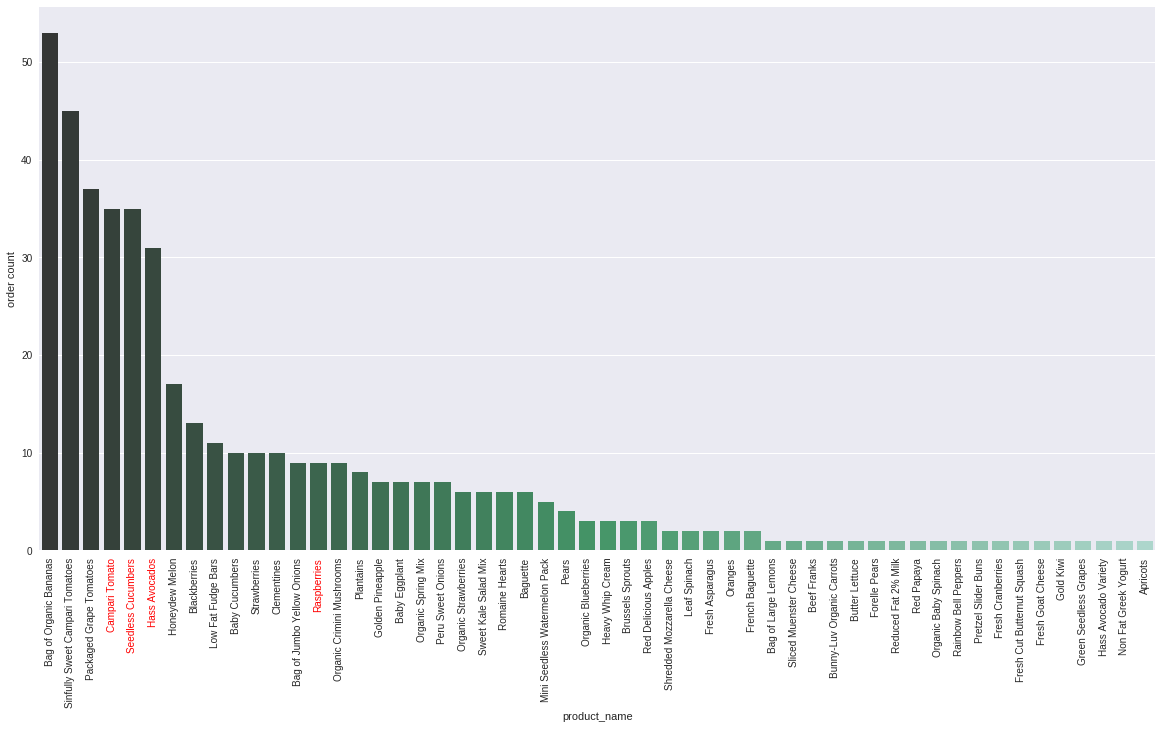

------ Plots for user_id  77880 ------


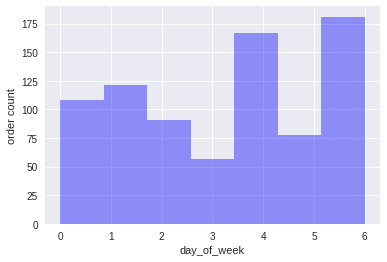

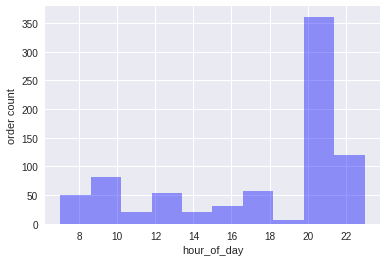

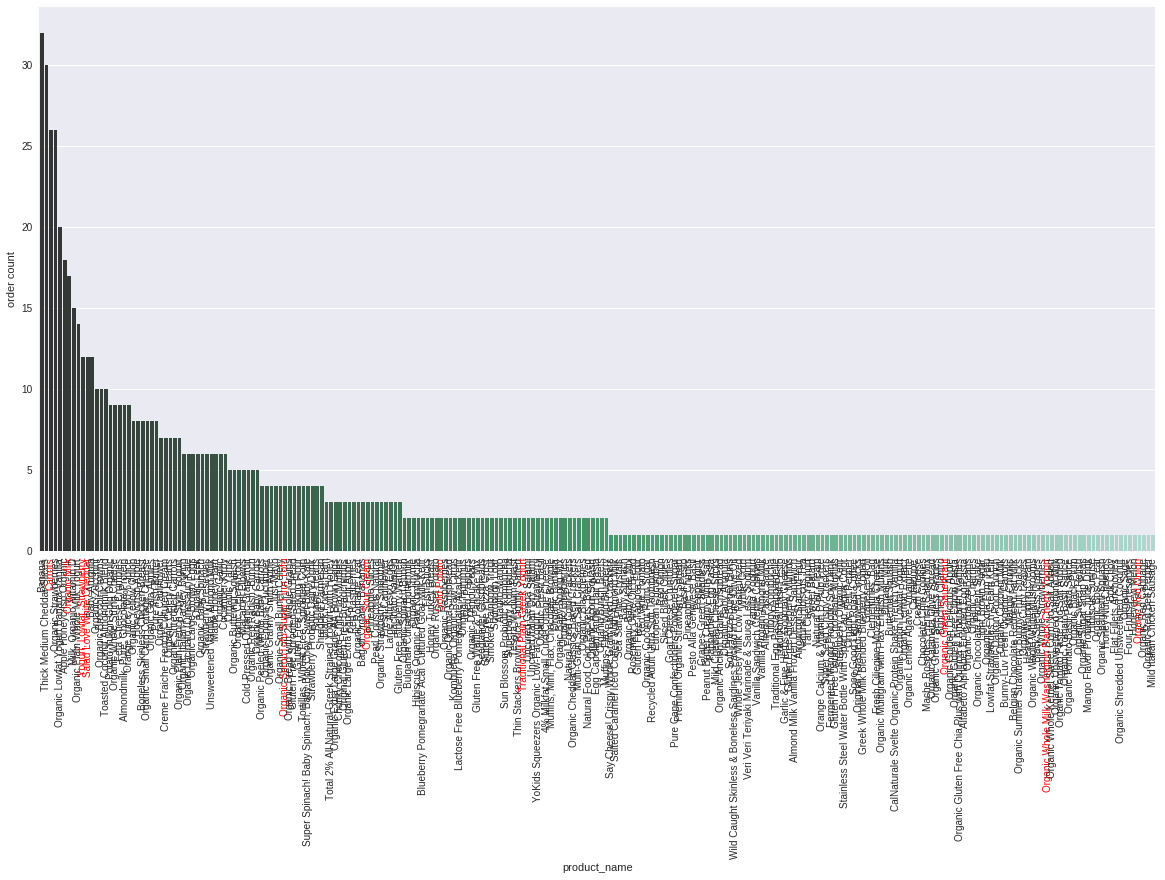

------ Plots for user_id  190456 ------


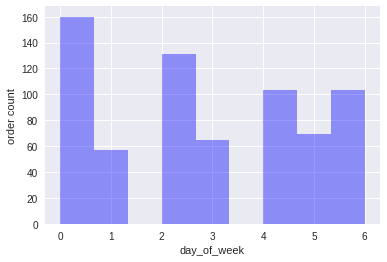

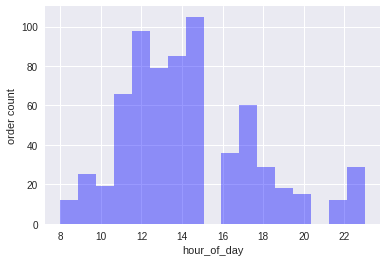

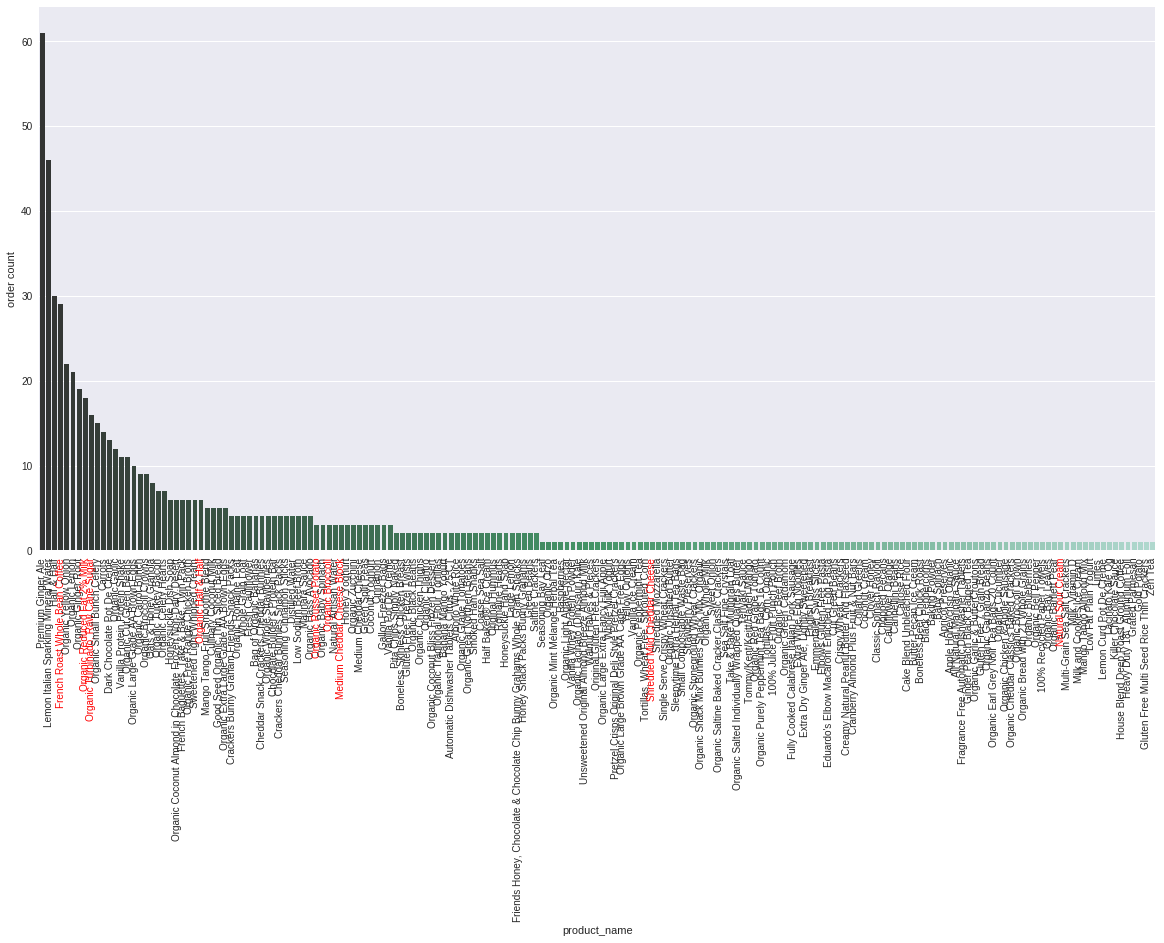

In [97]:
N_TOP_USERS = 10
for user_id in top_users.head(N_TOP_USERS).user_id.values:
    generate_user_plots(user_id)